
# <font color=#e08040> Aplicaciones de Análisis </font>

## <font color=#e08040 >Práctica 2 </font>


<font color=#19507b >Antonio Sanz Corbalán </font>

<font color=#19507b >28 de Marzo 2020 </font>


# Enunciado de la práctica

Disponemos de un set de imágenes etiquetadas (Dataset.zip) como: cloudy, rain, shine, y sunrise.

El objetivo de la práctica consiste en crear un modelo que nos permita determinar, a partir de una imágen de test, la etiqueta correcta de nuestra imágen. Se requiere una precisión mínima de entrenamiento del 94%. Llegado este punto se debe parar el entrenamiento.

Dada la complejidad del problema, se deberá:

- probar diferentes optimizadores
- learning_rate
- epochs, batch_size, steps_per_epoch.
- diferentes callbacks (ayudan)

Para cada una de estas comprobaciones, dar una breve explicación su funcionamiento y de los resultados obtenidos.

Finalmente, explicar porqué se ha seleccionado un modelo y no otro y compartir las experiencias del "camino recorrido"

**Es muy recomendable ir guardando el modelo por si tenemos problemas de estabilidad / rendimiento**

In [0]:
%tensorflow_version 2.x

import tensorflow as tf
import subprocess
import os
import numpy as np
import matplotlib.pyplot  as plt
from keras import optimizers
from keras.models import load_model
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.constraints import maxnorm
from keras.layers.convolutional import Convolution2D
from keras.layers.convolutional import MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator

%matplotlib inline


# Preparación unidad Drive

In [172]:
from google.colab import drive

drivedir = '/content/gdrive'

drive.mount(drivedir)

print('Google Drive mount completed')

#check correct mount of drive directory
!df -h

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Google Drive mount completed
Filesystem      Size  Used Avail Use% Mounted on
overlay          69G   32G   34G  49% /
tmpfs            64M     0   64M   0% /dev
tmpfs           6.4G     0  6.4G   0% /sys/fs/cgroup
/dev/sda1        75G   38G   38G  50% /opt/bin
tmpfs           6.4G   20K  6.4G   1% /var/colab
shm             5.8G  4.0K  5.8G   1% /dev/shm
tmpfs           6.4G     0  6.4G   0% /proc/acpi
tmpfs           6.4G     0  6.4G   0% /proc/scsi
tmpfs           6.4G     0  6.4G   0% /sys/firmware
drive            15G  5.7G  9.4G  38% /content/gdrive


# Función Callback

In [0]:
ACCURACY_THRESHOLD = 0.94

class MinAccuracy(tf.keras.callbacks.Callback):
	def on_epoch_end(self, epoch, logs={}):
		if(logs.get('accuracy') > ACCURACY_THRESHOLD):
			print("\nSe ha alcanzado un precisión del %2.2f%% , paramos entrenamiento!!" %(ACCURACY_THRESHOLD*100))
			self.model.stop_training = True

# Stop training when a monitored quantity has stopped improving.
# patience: number of epochs that produced the monitored quantity with no improvement after which training will be stopped.

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4, verbose=1, min_delta=1e-4)  

# Reduce learning rate when a metric has stopped improving.
# This callback monitors a quantity and if no improvement is seen for a 'patience' number of epochs, the learning rate is reduced.

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4, verbose=1, min_delta=1e-4)  


# Instanciamos objeto MinAccuracy
min_accuracy = MinAccuracy()

callbacks_list = [min_accuracy, early_stop, reduce_lr]

# Paths

Definir dos variables con las rutas para los datos de train y de test

In [0]:
prac_dir = drivedir + '/My Drive/p3TensorFlow' # Directorio Padre


train_dir = prac_dir + '/train' # Directorio datos train
test_dir = prac_dir + '/test' # Directorio datos test


os.chdir(prac_dir) # Nos desplazamos al dreictorio padre

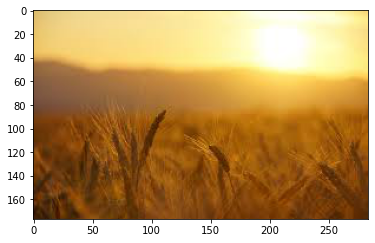

In [175]:
from PIL import Image
import random

# IMAGEN DE MUESTRA SUNRISE

i = random.randint(0,250) 
image = Image.open(train_dir + '/sunrise/sunrise'+ str(i) +'.jpg')  
imgplot = plt.imshow(image)  
plt.show()  

# ImageDataGenerator

In [0]:
# HIPERPARAMETROS 

L_RATE  = 0.001
EPOCHS = 50
VAL_SAMPLES = 400
TRAIN_SAMPLES = 1125
BATCH_SIZE = 16
DECAY = L_RATE / EPOCHS

IMAGE_RESIZE = 224
NUM_CLASSES = 4

In [0]:
# AUMENTAMOS CONJUNTO DE DATOS DE ENTRENAMIENTO

train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range = 0.1,
    zoom_range = 0.2,
    rotation_range = 5,
    horizontal_flip = True,
    brightness_range = [0.2,0.8]
    )

test_datagen = ImageDataGenerator(rescale=1./255)

In [178]:
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(IMAGE_RESIZE,IMAGE_RESIZE),
        batch_size=BATCH_SIZE,
        class_mode='categorical'
        )

validation_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(IMAGE_RESIZE,IMAGE_RESIZE),
        batch_size=BATCH_SIZE,
        class_mode='categorical'
        )

Found 1125 images belonging to 4 classes.
Found 400 images belonging to 4 classes.


# Modelo

In [179]:
# ARQUITECTURA RED CONVOLUCIONAL


modelo = tf.keras.Sequential()
modelo.add(tf.keras.layers.Convolution2D(32, 3, 3, input_shape=(IMAGE_RESIZE, IMAGE_RESIZE, 3), padding='same', activation='relu'))
modelo.add(tf.keras.layers.Dropout(0.2))
modelo.add(tf.keras.layers.Convolution2D(32, 3, 3, activation='relu')) # Antes 64 y kernel de 3x3
modelo.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
modelo.add(tf.keras.layers.Convolution2D(64, 3, 3, activation='relu'))  # 128
modelo.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))


modelo.add(tf.keras.layers.Flatten())
modelo.add(tf.keras.layers.Dense(512, activation='relu')) # Antes 1024
modelo.add(tf.keras.layers.Dense(NUM_CLASSES, activation='softmax'))

modelo.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_36 (Conv2D)           (None, 75, 75, 32)        896       
_________________________________________________________________
dropout_22 (Dropout)         (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 25, 25, 32)        9248      
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 4, 4, 64)          18496     
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 2, 2, 64)          0         
_________________________________________________________________
flatten_10 (Flatten)         (None, 256)             

In [180]:
# ARQUITECTURA CIFAR-10 

"""
modelo = tf.keras.Sequential()
modelo.add(tf.keras.layers.Conv2D(32, (3, 3), padding='same',
                 input_shape=(IMAGE_RESIZE, IMAGE_RESIZE, 3)))
modelo.add(tf.keras.layers.Activation('relu'))
modelo.add(tf.keras.layers.Conv2D(32, (3, 3)))
modelo.add(tf.keras.layers.Activation('relu'))
modelo.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
modelo.add(tf.keras.layers.Dropout(0.25))

modelo.add(tf.keras.layers.Conv2D(64, (3, 3), padding='same'))
modelo.add(tf.keras.layers.Activation('relu'))
modelo.add(tf.keras.layers.Conv2D(64, (3, 3)))
modelo.add(tf.keras.layers.Activation('relu'))
modelo.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
modelo.add(tf.keras.layers.Dropout(0.25))

modelo.add(tf.keras.layers.Flatten())
modelo.add(tf.keras.layers.Dense(512))
modelo.add(tf.keras.layers.Activation('relu'))
modelo.add(tf.keras.layers.Dropout(0.5))
modelo.add(tf.keras.layers.Dense(NUM_CLASSES))
modelo.add(tf.keras.layers.Activation('softmax'))

modelo.summary()
"""

"\nmodelo = tf.keras.Sequential()\nmodelo.add(tf.keras.layers.Conv2D(32, (3, 3), padding='same',\n                 input_shape=(IMAGE_RESIZE, IMAGE_RESIZE, 3)))\nmodelo.add(tf.keras.layers.Activation('relu'))\nmodelo.add(tf.keras.layers.Conv2D(32, (3, 3)))\nmodelo.add(tf.keras.layers.Activation('relu'))\nmodelo.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))\nmodelo.add(tf.keras.layers.Dropout(0.25))\n\nmodelo.add(tf.keras.layers.Conv2D(64, (3, 3), padding='same'))\nmodelo.add(tf.keras.layers.Activation('relu'))\nmodelo.add(tf.keras.layers.Conv2D(64, (3, 3)))\nmodelo.add(tf.keras.layers.Activation('relu'))\nmodelo.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))\nmodelo.add(tf.keras.layers.Dropout(0.25))\n\nmodelo.add(tf.keras.layers.Flatten())\nmodelo.add(tf.keras.layers.Dense(512))\nmodelo.add(tf.keras.layers.Activation('relu'))\nmodelo.add(tf.keras.layers.Dropout(0.5))\nmodelo.add(tf.keras.layers.Dense(NUM_CLASSES))\nmodelo.add(tf.keras.layers.Activation('softmax'))\n\nmodelo

In [0]:
# OPTIMIZADORES

#rms = tf.keras.optimizers.RMSprop(learning_rate=L_RATE, rho=0.9)
adam = tf.keras.optimizers.Adam(learning_rate=L_RATE, beta_1=0.9, beta_2=0.999, amsgrad=False)
#adamax = tf.keras.optimizers.Adamax(lr=L_RATE, beta_1=0.9, beta_2=0.999)
#sgd = tf.keras.optimizers.SGD(lr=L_RATE, decay=DECAY, momentum=0.9, nesterov=True)

modelo.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

In [182]:
# ENTRENAMIENTO MODELO 

m = modelo.fit_generator(
          train_generator,
          steps_per_epoch = TRAIN_SAMPLES // BATCH_SIZE, 
          epochs = EPOCHS,
          validation_data = validation_generator,
          callbacks = callbacks_list,
          validation_steps = VAL_SAMPLES // BATCH_SIZE
          )

# ALMACENAMOS LOS PESOS DE NUESTRO MODELO ENTRENADO

modelo.save_weights(prac_dir + "/modelo_"+str(EPOCHS)+"_"+str(BATCH_SIZE)+".h5")
print("Saved model to disk")

Epoch 1/50
70/70 [==============================] - 26s 365ms/step - loss: 0.9453 - accuracy: 0.6027 - val_loss: 0.7174 - val_accuracy: 0.6850
Epoch 2/50
70/70 [==============================] - 26s 372ms/step - loss: 0.6351 - accuracy: 0.7304 - val_loss: 0.6565 - val_accuracy: 0.7200
Epoch 3/50
70/70 [==============================] - 25s 362ms/step - loss: 0.6125 - accuracy: 0.7565 - val_loss: 0.5914 - val_accuracy: 0.7800
Epoch 4/50
70/70 [==============================] - 26s 366ms/step - loss: 0.5178 - accuracy: 0.8070 - val_loss: 0.6171 - val_accuracy: 0.7575
Epoch 5/50
70/70 [==============================] - 25s 356ms/step - loss: 0.5060 - accuracy: 0.7980 - val_loss: 0.5444 - val_accuracy: 0.8050
Epoch 6/50
70/70 [==============================] - 26s 369ms/step - loss: 0.4652 - accuracy: 0.8224 - val_loss: 0.5719 - val_accuracy: 0.7975
Epoch 7/50
70/70 [==============================] - 24s 350ms/step - loss: 0.4806 - accuracy: 0.8151 - val_loss: 0.4504 - val_accuracy: 0.8200

In [0]:

# load weights into new model
#model = modelo.load_weights(prac_dir + "/modelo_"+str(EPOCHS)+"_"+str(BATCH_SIZE)+".h5")
#print("Loaded model from disk")

# Comprobación de resultados

In [184]:
# Completar aqui evaluando la calidad de tu modelo, con gráficas donde se muestra la evolución
# entre entrenamiento y test

m.history['accuracy'][-1]

0.9431920647621155

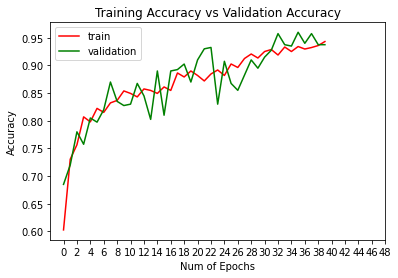

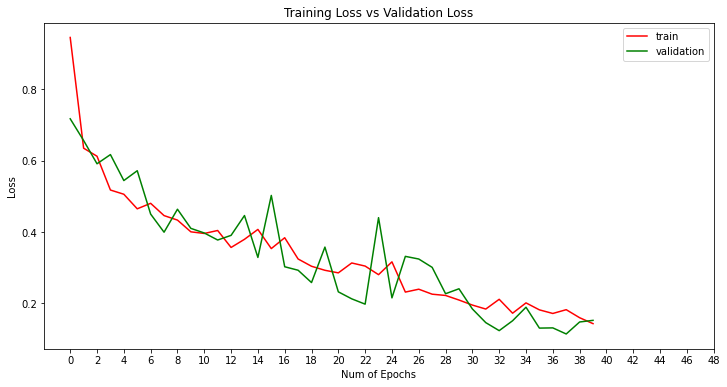

In [185]:
plt.figure(0)  
plt.plot(m.history['accuracy'],'r')  
plt.plot(m.history['val_accuracy'],'g')  
plt.xticks(np.arange(0, EPOCHS, 2.0))  
plt.rcParams['figure.figsize'] = (12, 6)  
plt.xlabel("Num of Epochs")  
plt.ylabel("Accuracy")  
plt.title("Training Accuracy vs Validation Accuracy")  
plt.legend(['train','validation'])

plt.figure(1)  
plt.plot(m.history['loss'],'r')  
plt.plot(m.history['val_loss'],'g')  
plt.xticks(np.arange(0, EPOCHS, 2.0))  
plt.rcParams['figure.figsize'] = (12, 6)  
plt.xlabel("Num of Epochs")  
plt.ylabel("Loss")  
plt.title("Training Loss vs Validation Loss")  
plt.legend(['train','validation'])

plt.show() 

In [0]:
def predict_one(model):  
    image_batch, classes_batch = next(validation_generator)
    predicted_batch = model.predict(image_batch)
    for k in range(0,5):
      image = image_batch[k]
      pred = predicted_batch[k]
      the_pred = np.argmax(pred)
      predicted = class_names[the_pred]
      val_pred = max(pred)
      the_class = np.argmax(classes_batch[k])
      value = class_names[np.argmax(classes_batch[k])]
      plt.figure(k)
      isTrue = (the_pred == the_class)
      plt.title(str(isTrue) + ' - class: ' + value + ' - ' + 'predicted: ' + predicted + '[' + str(val_pred) + ']')
      plt.imshow(image)

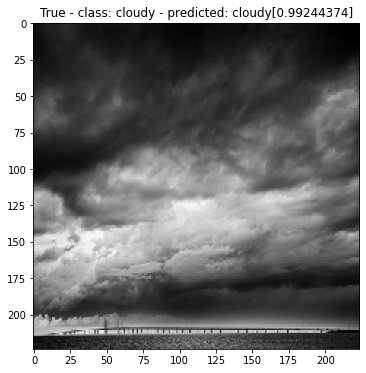

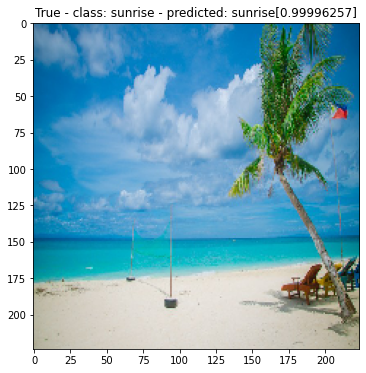

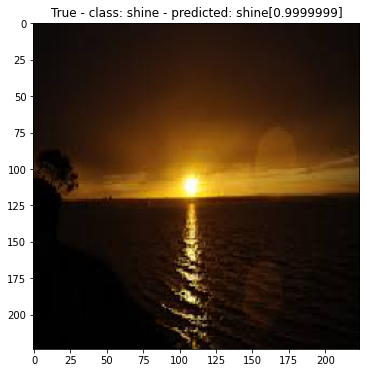

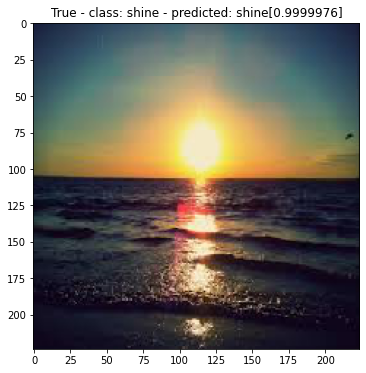

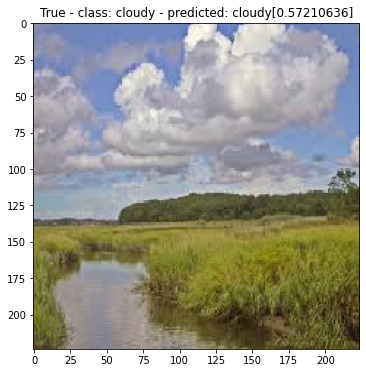

In [187]:
class_names = ['cloudy', 'rain', 'sunrise', 'shine']
predict_one(modelo)  

# Echar un vistazo a las imágenes para comprobar los resultados

- batch_size determines the number of samples in each mini batch. Its maximum is the number of all samples, which makes gradient descent accurate, the loss will decrease towards the minimum if the learning rate is small enough, but iterations are slower. Its minimum is 1, resulting in stochastic gradient descent: Fast but the direction of the gradient step is based only on one example, the loss may jump around. batch_size allows to adjust between the two extremes: accurate gradient direction and fast iteration. Also, the maximum value for batch_size may be limited if your model + data set does not fit into the available (GPU) memory.


- steps_per_epoch the number of batch iterations before a training epoch is considered finished. If you have a training set of fixed size you can ignore it but it may be useful if you have a huge data set or if you are generating random data augmentations on the fly, i.e. if your training set has a (generated) infinite size. If you have the time to go through your whole training data set I recommend to skip this parameter.

- validation_steps similar to steps_per_epoch but on the validation data set instead on the training data. If you have the time to go through your whole validation data set I recommend to skip this parameter.